In [1]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Reshape,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.layers import GlobalMaxPooling2D, Conv3D, MaxPooling3D, ConvLSTM2D, Add
from keras.models import Model
from keras.initializers import Constant
import tensorflow as tf

import pickle


Using TensorFlow backend.


# TEXT SECTION OF THE MODEL

In [ ]:
MAX_UTTERANCE_LENGTH = 20
MAX_NUM_WORDS = 20000

In [ ]:
#Load the data
pickle_text = open("X_dev_text_utterances.pickle","rb")
X_dev_text_utterances = pickle.load(pickle_text)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\x97\x92\x98\x85\x91')
tokenizer.fit_on_texts(X_dev_text_utterances)
X_dev_text_sequences = tokenizer.texts_to_sequences(X_dev_text_utterances)
X_dev_data_text = pad_sequences(X_dev_text_sequences, maxlen=MAX_UTTERANCE_LENGTH)

In [ ]:
X_dev_data_text.shape  # <---- This is the data to be fed as input to the NN

In [12]:
X_dev_embedding_matrix = open("X_dev_embedding.pickle","rb")
X_dev_embedding_matrix = pickle.load(X_dev_embedding_matrix)

In [13]:
num_words = len(X_dev_embedding_matrix)
EMBEDDING_DIM = X_dev_embedding_matrix.shape[1]

In [14]:
print(num_words)

1482


In [15]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(X_dev_embedding_matrix),
                            input_length=MAX_UTTERANCE_LENGTH,
                            trainable=False)

In [16]:
input_text_ = Input(shape = (MAX_UTTERANCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(input_text_)
output_text_ = Conv1D(64, 5, activation='relu')(embedded_sequences)
output_text_ = MaxPooling1D(2)(output_text_)
output_text_ = Conv1D(100, 5, activation='relu')(output_text_)
output_text_ = GlobalMaxPooling1D()(output_text_) #as in paper 100D textual features

model_text = Model(inputs = input_text_, outputs = output_text_)
model_text.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 300)           444600    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            96064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4, 100)            32100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
Total params: 572,764
Trainable params: 128,164
Non-trainable params: 444,600
_______________________________________________

# FRAME SECTION OF THE MODEL

In [1]:
#Load frame data
pickle_frame = open("X_dev_frame_float32.pickle","rb")
X_dev_frame_float32 = pickle.load(pickle_frame)

# Normalize Image
X_dev_frame_float32 = X_dev_frame_float32/255.0
# plt.imshow(X_dev_frame_float32[0][0])
print(X_dev_frame_float32.shape)

In [17]:
input_frame_ = Input(shape = (10, 84, 150, 3))

output_frame_ = ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='valid', return_sequences=False)(input_frame_) #To understand more about return_sequences 
output_frame_ = BatchNormalization()(output_frame_)                                     #https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/
output_frame_ = MaxPooling2D((2, 2), strides = 2)(output_frame_)

output_frame_ = Conv2D(64, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(128, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(64, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(32, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
# output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Flatten()(output_frame_)

# model = Model(inputs = [input_frame_], outputs = output_frame_)
# model.summary()

# AUDIO SECTION OF THE MODEL

In [18]:
#Load audio mfcc 40D features

pickle_audio_mfcc = open("X_dev_audio_mfcc.pickle","rb")
X_dev_audio_mfcc = pickle.load(pickle_audio_mfcc)

In [19]:
X_dev_audio_mfcc = X_dev_audio_mfcc.reshape(1102, 10, 4)

In [20]:
X_dev_audio_mfcc.shape

(1102, 10, 4)

In [21]:
input_audio_ = Input(shape = (10, 4))
output_audio_ = Conv1D(16, 3, activation='relu')(input_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Conv1D(32, 3, activation='relu')(output_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Reshape((32,))(output_audio_)
# model_audio = Model(inputs = input_audio_, outputs = output_audio_)
# model_audio.summary()

# Concatenate Model

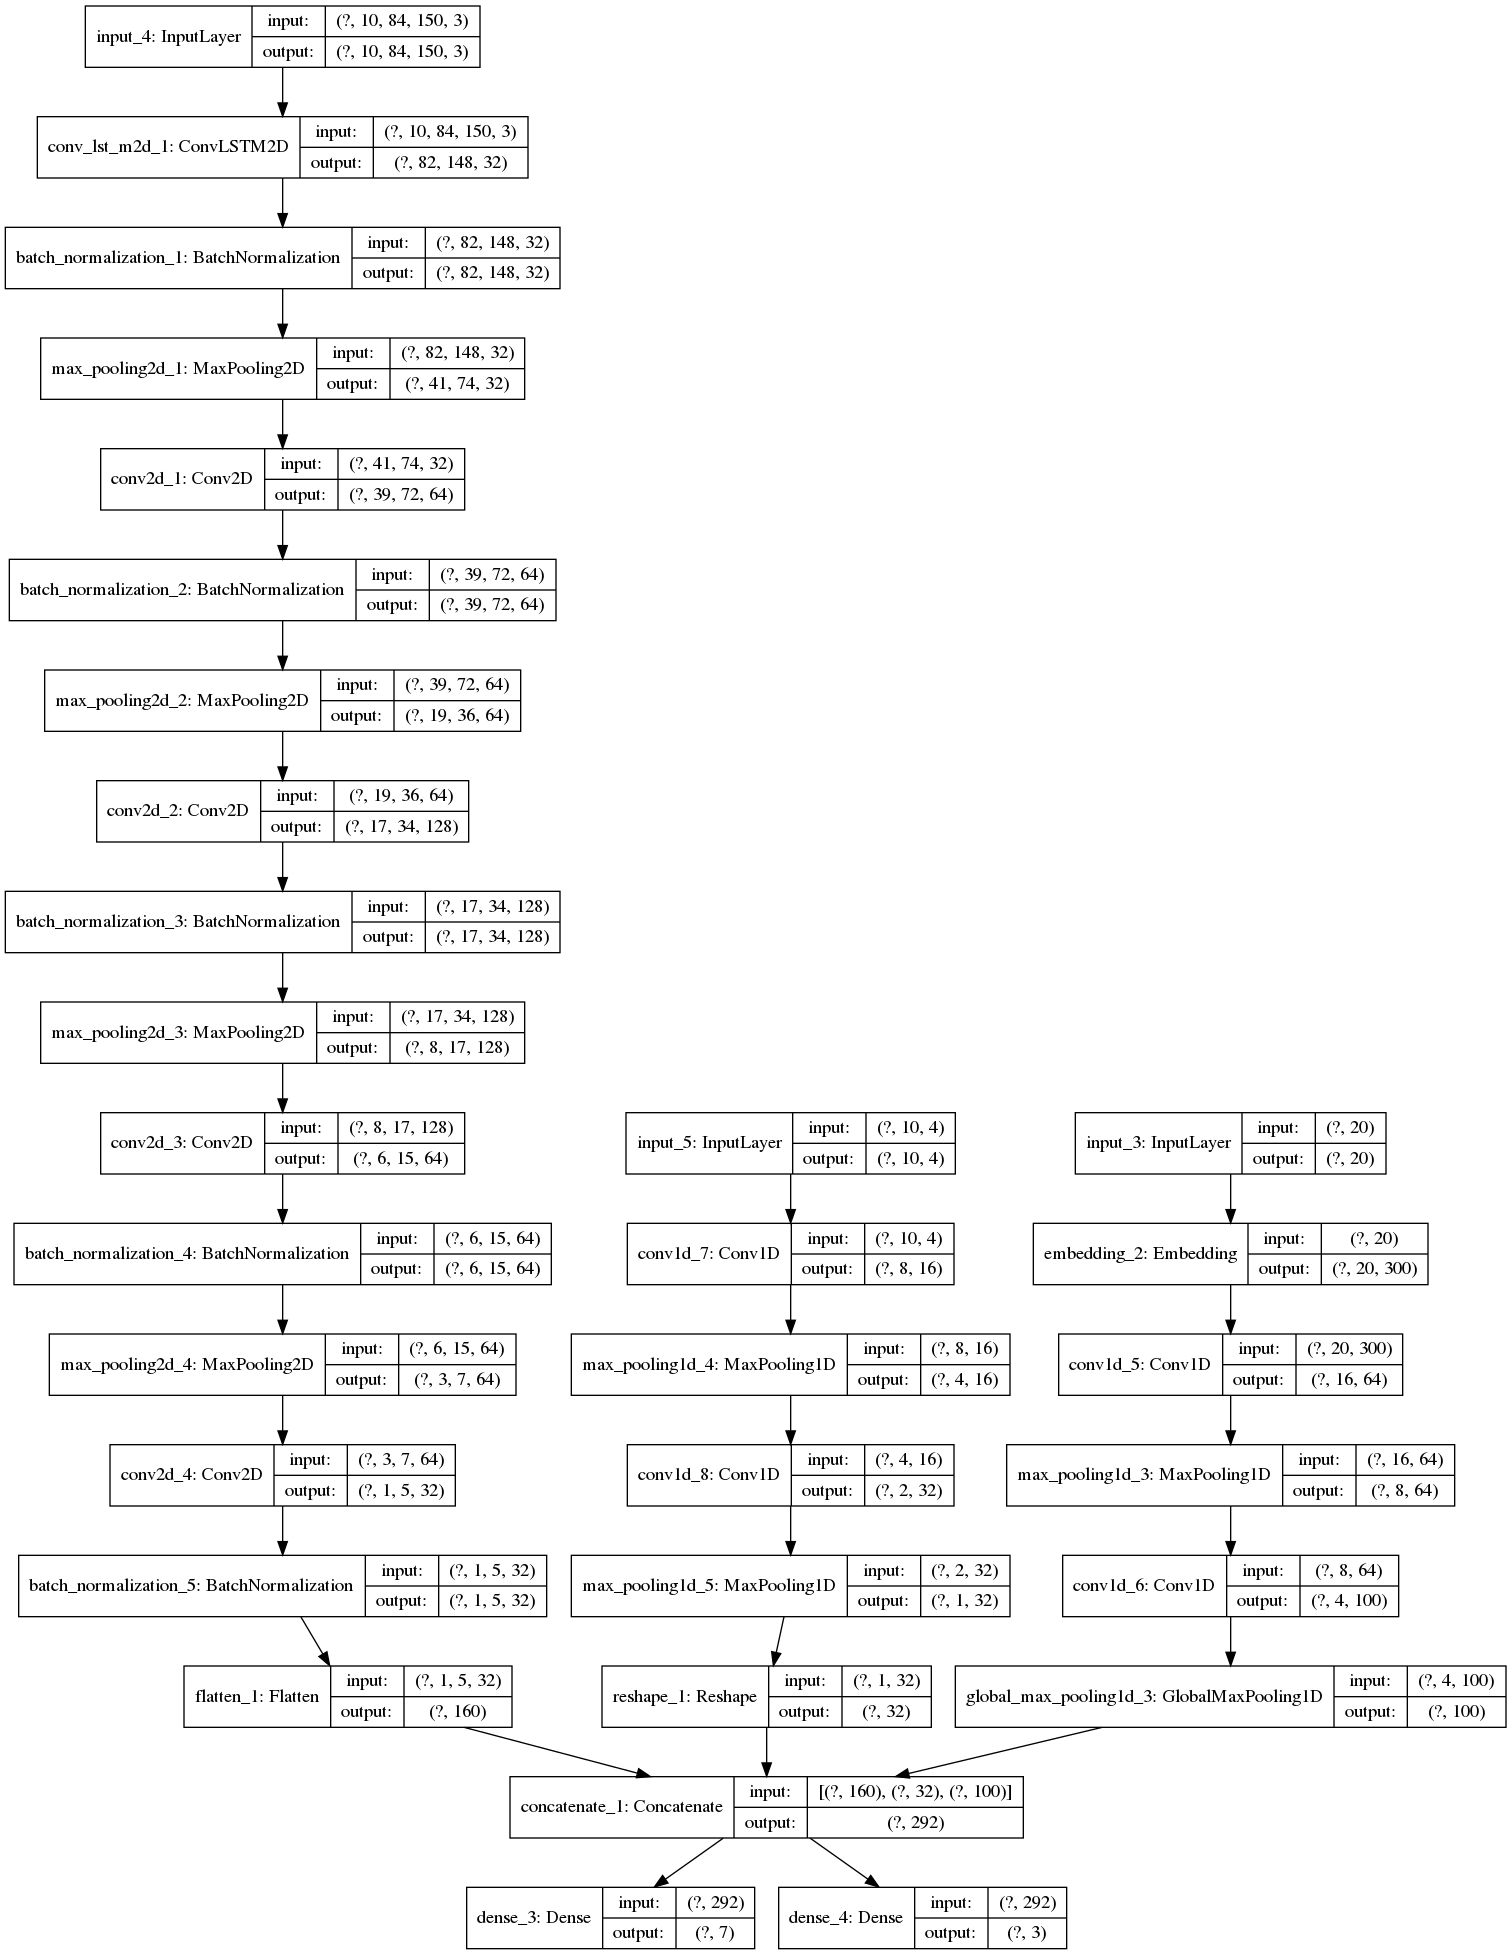

In [23]:
#Now concatenate all the layers to make a multimodal
concatenate = Concatenate()([output_frame_, output_audio_, output_text_])
y_predict_emotions = Dense(7, activation='softmax')(concatenate)
y_predict_sentiments = Dense(3, activation='softmax')(concatenate)
model = Model(inputs=[input_frame_, input_audio_, input_text_], outputs=[y_predict_emotions, y_predict_sentiments])
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10, 84, 150,  0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 82, 148, 32)  40448       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 82, 148, 32)  128         conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 41, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

# Y_prediction:  Label section of the model

In [30]:
pickle_y_dev = open("Y_dev_float32.pickle","rb")
Y_dev_float32 = pickle.load(pickle_y_dev)

In [31]:
Y_dev_float32_emotions = to_categorical(Y_dev_float32[:,0])   #keras.utils
Y_dev_float32_sentiments = to_categorical(Y_dev_float32[:,1])

print(Y_dev_float32_emotions.shape)
print(Y_dev_float32_sentiments.shape)

(1102, 7)
(1102, 3)


### If need to inverse the one_hot_encoding
from numpy import argmax

data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
data = array(data)

encoded = to_categorical(data) # one hot encoe

inverted = argmax(encoded[0]) # invert encoding

# REMEMBER THE OPTIMIZATIONS

In [52]:
#Optimizations => image for audio, separable conv, augmentation, dropout, who is the speaker in the dataset,
# Optimizers = adam, etc. (Study), optimize nn using keras tuner

# DEFINE MODEL

In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# log_dir= path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

filepath = "save_checkpoint/" + "final_weights_improvement-{epoch:02d}-{val_acc:3f}.hdf5"

early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [ ]:
# fit network
history = model.fit([X_dev_frame_float32], [Y_dev_float32_emotions, Y_dev_float32_sentiments],
                    epochs = 50,
                    batch_size=64,
                    validation_split=0.25,
                    callbacks = [early_stop])

Train on 826 samples, validate on 276 samples
Epoch 1/50


In [35]:
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#Save history pickle